In [376]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [377]:
# Encoding legend
ENCODING_LEGEND = {
    0: 'Not Vital', 1: 'MRI_CCS_11', 2: 'MRI_EXU_95', 3: 'MRI_FRR_18',
    4: 'MRI_FRR_257', 5: 'MRI_FRR_264', 6: 'MRI_FRR_3', 7: 'MRI_FRR_34',
    8: 'MRI_MPT_1005', 9: 'MRI_MSR_100', 10: 'MRI_MSR_104', 11: 'MRI_MSR_21', 12: 'MRI_MSR_34'
}

In [378]:
# Load and inspect data
data = pd.read_csv('encoded_182625_training.csv')
print(data.head())

   order_id  sourceID  timediff     PTAB  BodyGroup_from  BodyGroup_to
0         1      10.0       0.0 -1182200               9             9
1         2       0.0      40.0 -1182200               9             9
2         3       4.0      45.0 -1181050               9             9
3         4       5.0      52.0 -1181050               9             9
4         5       5.0      68.0 -1181050               9             9


In [ ]:
# Prepare input (X) and output (y)
X = data[['sourceID', 'PTAB', 'BodyGroup_from', 'BodyGroup_to']].values
y = data['timediff'].values # sum of timediff 

In [380]:
# Reshape X for LSTM input
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

original_indices = data.index  # Save original indices

Shape of X: (3800, 1, 4)
Shape of y: (3800,)


In [381]:
# Split dataset
X_train, X_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(
    X, y, original_indices, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test, val_indices, test_indices = train_test_split(
    X_temp, y_temp, temp_indices, test_size=0.625, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (2280, 1, 4) (2280,)
Validation set shape: (570, 1, 4) (570,)
Test set shape: (950, 1, 4) (950,)


In [382]:
# Custom loss function
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))
    zero_penalty = K.sum(K.square(y_pred) * K.cast(K.equal(y_true, 0), K.floatx()))
    return mse_loss + zero_penalty

In [383]:
# LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss=custom_loss)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2006332160.0000 - val_loss: 210959.3594
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19218692.0000 - val_loss: 1085096.7500
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21616950.0000 - val_loss: 352426.5312
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5800725.0000 - val_loss: 708629.1875
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 366567264.0000 - val_loss: 754437.6875
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2452123.2500 - val_loss: 442796.7188
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2187889.0000 - val_loss: 297919.3125
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2388626.2500 - val_loss: 223427.8594
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 541164.2500 - val_loss: 207570.6875
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 351631.7188 - val_loss: 202942.7656
Epoch 11/100
72/72 ━━━━━━━━━━━━━━

In [384]:
model.save('trained_model.h5')

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 176203.8594

Test Loss: 160274.65625


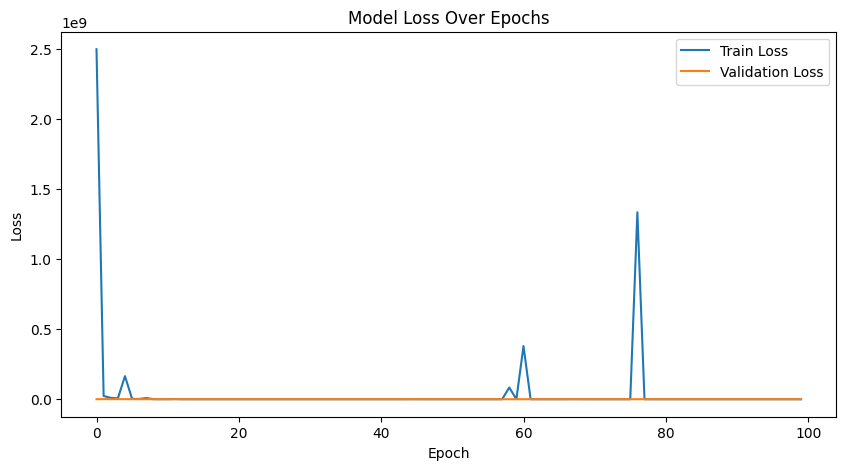

In [385]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss}")

# %%
# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [386]:
# Make predictions
predictions = model.predict(X_test).flatten()

# Post-process predictions to enforce zero constraint
predictions = np.where(y_test == 0, 0, predictions)

# Decode sourceIDs
decoded_sourceIDs = [ENCODING_LEGEND[int(data.loc[idx, 'sourceID'])] for idx in test_indices]

# Combine predictions with sourceIDs
results_df = pd.DataFrame({
    'SourceID': decoded_sourceIDs,
    'True Timediff': y_test,
    'Predicted Timediff': predictions
})
print(results_df.head())

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
      SourceID  True Timediff  Predicted Timediff
0   MRI_CCS_11          234.0            1.399487
1  MRI_FRR_257          311.0            1.399487
2  MRI_FRR_264          465.0           37.551949
3  MRI_MSR_104            0.0            0.000000
4  MRI_FRR_264           33.0            1.399487


In [387]:
# Save predictions to CSV
results_df.to_csv('predictions_with_sourceID.csv', index=False)
print("Predictions saved to 'predictions_with_sourceID.csv'")

Predictions saved to 'predictions_with_sourceID.csv'


In [388]:
# Evaluate performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")

Mean Absolute Error (MAE): 229.12501709373373
Mean Squared Error (MSE): 159083.81575917176
R-Squared (R²): -0.4754693483693331


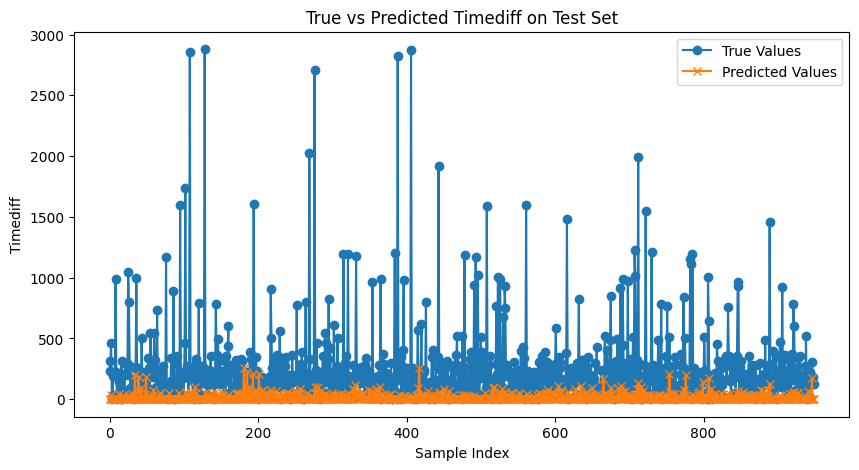

In [389]:
# Plot true vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(predictions, label='Predicted Values', marker='x')
plt.title('True vs Predicted Timediff on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Timediff')
plt.legend()
plt.show()

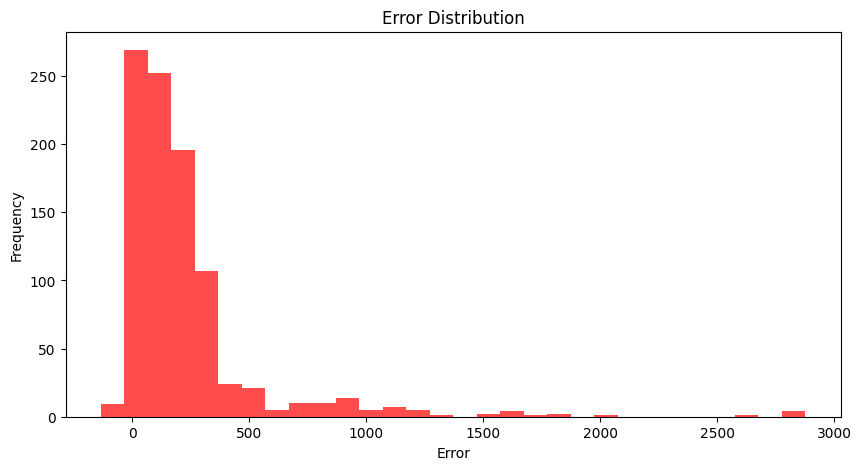

In [390]:
# Plot error distribution
errors = y_test - predictions

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, color='red', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [391]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

In [392]:
# Load the new dataset (only sourceID, BodyGroup_from, BodyGroup_to)
new_data = pd.read_csv('predicSourceIDandBodyGroup_182625.csv')
print("New Data Loaded:")
print(new_data.head())

New Data Loaded:
      sourceID BodyGroup_from BodyGroup_to
0  MRI_MSR_104        ABDOMEN      ABDOMEN
1   MRI_MSR_21        ABDOMEN      ABDOMEN
2  MRI_FRR_257        ABDOMEN      ABDOMEN
3  MRI_FRR_264        ABDOMEN      ABDOMEN
4    MRI_FRR_3        ABDOMEN      ABDOMEN


In [393]:
# Encoding legend
ENCODING_LEGEND = {
    'Not Vital': 0, 'MRI_CCS_11': 1, 'MRI_EXU_95': 2, 'MRI_FRR_18': 3, 'MRI_FRR_257': 4,
    'MRI_FRR_264': 5, 'MRI_FRR_3': 6, 'MRI_FRR_34': 7, 'MRI_MPT_1005': 8,
    'MRI_MSR_100': 9, 'MRI_MSR_104': 10, 'MRI_MSR_21': 11, 'MRI_MSR_34': 12
}
# BodyGroup encoding legend
BODYGROUP_ENCODING = {
    'ABDOMEN': 1, 'ARM': 2, 'HEAD': 3, 'HEART': 4, 'HIP': 5,
    'KNEE': 6, 'LEG': 7, 'PELVIS': 8, 'SHOULDER': 9, 'SPINE': 10
}


In [394]:
# Reverse encoding legend for decoding
source_decoding_legend = {v: k for k, v in ENCODING_LEGEND.items()}
bodygroup_decoding_legend = {v: k for k, v in BODYGROUP_ENCODING.items()}

# Check if the new data contains the required columns
required_columns = ['sourceID', 'BodyGroup_from', 'BodyGroup_to']
if not all(col in new_data.columns for col in required_columns):
    raise KeyError(f"The following required columns are missing in the new data: {set(required_columns) - set(new_data.columns)}")

In [395]:
# Encode sourceID and BodyGroup columns using the legends
new_data['sourceID_encoded'] = new_data['sourceID'].map(ENCODING_LEGEND)
new_data['BodyGroup_from_encoded'] = new_data['BodyGroup_from'].map(BODYGROUP_ENCODING)
new_data['BodyGroup_to_encoded'] = new_data['BodyGroup_to'].map(BODYGROUP_ENCODING)

# Check for any missing encodings
if new_data[['sourceID_encoded', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded']].isnull().any().any():
    print("Warning: Some values were not found in the encoding legends.")
    print(new_data[new_data[['sourceID_encoded', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded']].isnull().any(axis=1)])

          sourceID BodyGroup_from BodyGroup_to  sourceID_encoded   
223  MRI_MSR_100',        ABDOMEN      ABDOMEN               NaN  \
457  MRI_MSR_100',        ABDOMEN      ABDOMEN               NaN   
481  MRI_MSR_100',        ABDOMEN      ABDOMEN               NaN   

     BodyGroup_from_encoded  BodyGroup_to_encoded  
223                       1                     1  
457                       1                     1  
481                       1                     1  


In [396]:
# Fill missing encodings with a default value (e.g., 0)
new_data['sourceID_encoded'] = new_data['sourceID_encoded'].fillna(0)
new_data['BodyGroup_from_encoded'] = new_data['BodyGroup_from_encoded'].fillna(0)
new_data['BodyGroup_to_encoded'] = new_data['BodyGroup_to_encoded'].fillna(0)

In [397]:
# Prepare the input for prediction
X_new = new_data[['sourceID_encoded', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded']].values
X_new = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))

print("Shape of New Data for Prediction:", X_new.shape)

Shape of New Data for Prediction: (1156, 1, 3)


In [398]:
# Drop rows with missing encodings (if any)
new_data = new_data.dropna(subset=['sourceID_encoded', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded'])

In [399]:
# Load the pre-trained model
try:
    model = load_model('trained_model.h5', custom_objects={'custom_loss': custom_loss})
except FileNotFoundError:
    raise FileNotFoundError("The trained model file 'trained_model.h5' was not found. Please ensure the file exists in the specified directory.")

In [400]:
# Add a dummy PTAB column with a default value (e.g., 0)
new_data['PTAB'] = 0

# Prepare the input for prediction
X_new = new_data[['sourceID_encoded', 'PTAB', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded']].values
X_new = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))

print("Shape of New Data for Prediction:", X_new.shape)
# Make predictions
predictions = model.predict(X_new).flatten()

Shape of New Data for Prediction: (1156, 1, 4)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [401]:
# Apply the special rule for zero values
special_zero_ids = ['MRI_MSR_104']  # Add any other sourceIDs that should have a zero prediction
special_zero_encoded = [ENCODING_LEGEND[id_] for id_ in special_zero_ids]

# Set predictions to 0 for specific sourceIDs
new_data['Predicted_timediff'] = [
    0 if sourceID in special_zero_encoded else pred
    for sourceID, pred in zip(new_data['sourceID_encoded'], predictions)
]

In [402]:
# Decode columns back to their original form
new_data['sourceID_decoded'] = new_data['sourceID_encoded'].map(source_decoding_legend)
new_data['BodyGroup_from_decoded'] = new_data['BodyGroup_from_encoded'].map(bodygroup_decoding_legend)
new_data['BodyGroup_to_decoded'] = new_data['BodyGroup_to_encoded'].map(bodygroup_decoding_legend)

# Drop the encoded columns (optional)
new_data = new_data.drop(columns=['sourceID_encoded', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded'])

# Reorder columns for clarity
new_data = new_data[['sourceID_decoded', 'BodyGroup_from_decoded', 'BodyGroup_to_decoded', 'Predicted_timediff']]

print("Predictions Added to New Data:")
print(new_data.head())

Predictions Added to New Data:
  sourceID_decoded BodyGroup_from_decoded BodyGroup_to_decoded   
0      MRI_MSR_104                ABDOMEN              ABDOMEN  \
1       MRI_MSR_21                ABDOMEN              ABDOMEN   
2      MRI_FRR_257                ABDOMEN              ABDOMEN   
3      MRI_FRR_264                ABDOMEN              ABDOMEN   
4        MRI_FRR_3                ABDOMEN              ABDOMEN   

   Predicted_timediff  
0            0.000000  
1           18.575588  
2           22.080616  
3           20.957489  
4           20.001537  


In [403]:
# Save the updated dataset
new_data.to_csv('182625_with_timediff_3.csv', index=False)
print("Updated dataset with predictions saved to 'new_data_with_predictions.csv'")

Updated dataset with predictions saved to 'new_data_with_predictions.csv'
